In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

def process_dataset(X, y, time_steps):
    Xs = []
    ys = []
    for i in range(time_steps, X.shape[0]):
      Xs.append(X[i-time_steps : i])
      ys.append(y[i : i+time_steps])
    return np.array(Xs), np.array(ys)

def train_val_splitter(target_dataset, train_percent):
    train_size = int(len(target_dataset) * train_percent)
    train, test = target_dataset[0:train_size], target_dataset[train_size:len(target_dataset)]
    return train, test

In [4]:
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, - tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [5]:
import keras

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="acc"),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
      f1_m
]

In [6]:
df = pd.read_excel("Dataset_Train.xlsx", 
                   parse_dates=['Date'], index_col="Date")

In [7]:
scaler      = MinMaxScaler()
df          = scaler.fit_transform(df)
train, val  = train_val_splitter(df, 0.9)

X_train = train[0:, :20]
X_val   = val[0:, :20]
y_train = train[0:, 29:32]
y_val   = val[0:, 29:32]

X_train, y_train = process_dataset(X_train, y_train, 1)
X_val, y_val     = process_dataset(X_val, y_val, 1)

In [8]:
def model_build(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units1', min_value=16, max_value=256, step=16), input_shape=(X_train.shape[1:]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(hp.Int('units2', min_value=16, max_value=256, step=16),activation="relu", return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(hp.Int('units3', min_value=16, max_value=256, step=16),activation="relu", return_sequences=True))
    model.add(Dropout(0.2))

    model.add(Dense(3, activation="softmax"))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-8)
    model.compile(loss=focal_loss(alpha=0.25), optimizer=opt, metrics=METRICS)
    return model

In [ ]:
tuner = kt.Hyperband(model_build, 
                     kt.Objective("val_f1_m", direction="max"),
                     max_epochs=100,
                     directory='HistoryTuner',
                     project_name='3Clasess')

In [10]:
monitor = EarlyStopping(monitor='val_f1_m', min_delta=1e-3, patience=20, 
                        verbose=1, mode='max', restore_best_weights=True)

In [ ]:
tuner.search(X_train, y_train, epochs=100, batch_size=10, callbacks=[monitor],
             validation_data=(X_val, y_val), shuffle=True)

In [12]:
best_hyper = tuner.get_best_hyperparameters(1)[0]
print(best_hyper.values)
n_best_models = tuner.get_best_models(num_models = 1)
print(n_best_models[0].summary())

{'units1': 32, 'units2': 80, 'units3': 224, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 32)             6784      
                                                                 
 dropout (Dropout)           (None, 1, 32)             0         
                                                                 
 batch_normalization (BatchN  (None, 1, 32)            128       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 1, 80)             36160     
                                                                 
 dropout_1 (Dropout)         (None, 1, 80)             0         
                                                           

In [13]:
model = tuner.hypermodel.build(best_hyper)
history = model.fit(X_train, y_train, epochs=100, batch_size=10, callbacks=[monitor],
             validation_data=(X_val, y_val), shuffle=True)

Epoch 1/100
132/132 [==============================] - 10s 23ms/step - loss: 0.0367 - acc: 0.5826 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7439 - prc: 0.5888 - f1_m: 0.0000e+00 - val_loss: 0.0394 - val_acc: 0.6575 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7808 - val_prc: 0.6003 - val_f1_m: 0.0000e+00
Epoch 2/100
132/132 [==============================] - 1s 10ms/step - loss: 0.0328 - acc: 0.6436 - precision: 0.8611 - recall: 0.0472 - auc: 0.7937 - prc: 0.6676 - f1_m: 0.0829 - val_loss: 0.0380 - val_acc: 0.6575 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8012 - val_prc: 0.6459 - val_f1_m: 0.0000e+00
Epoch 3/100
132/132 [==============================] - 1s 11ms/step - loss: 0.0300 - acc: 0.6481 - precision: 0.8729 - recall: 0.1988 - auc: 0.8162 - prc: 0.7081 - f1_m: 0.3144 - val_loss: 0.0361 - val_acc: 0.6575 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8196 - val_prc: 0.7081 - val_f1_m: 0.0000e+00
Epoch 4/1

In [ ]:
test_dataset = pd.read_excel("Dataset_Tes.xlsx",
                             parse_dates=['Date'], index_col="Date")
print(test_dataset.iloc[0:, :20])
print(test_dataset.iloc[0:, 29:32])

In [ ]:
test_dataset = scaler.transform(test_dataset)

X_test = test_dataset[0:, :20]
y_test = test_dataset[0:, 29:32]

X_test, y_test = process_dataset(X_test, y_test, 1)

In [16]:
score = model.evaluate(X_test, y_test, verbose = 0) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.03915072977542877
Test accuracy: 0.5635359287261963


In [17]:
prediction = model.predict(X_test)

In [ ]:
pred = prediction.reshape(-1, 3)
label= y_test.reshape(-1, 3)

y_pred = np.argmax(pred, axis=1)
y_label = np.argmax(label, axis=1)

cf= confusion_matrix(y_label, y_pred)
df_cm = pd.DataFrame(cf, columns=np.unique(y_label), index = np.unique(y_label))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

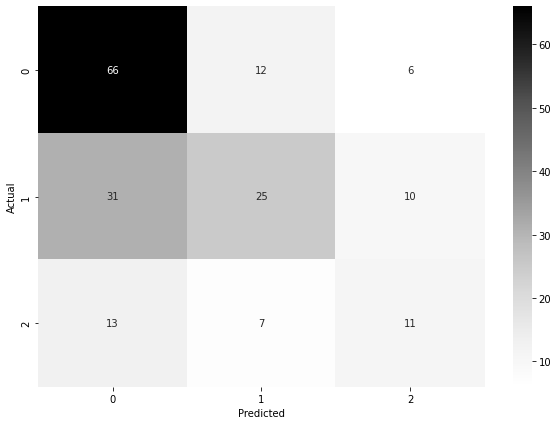

In [19]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, cmap="Greys", annot=True)

In [20]:
print(classification_report(y_pred, y_label))

              precision    recall  f1-score   support

           0       0.79      0.60      0.68       110
           1       0.38      0.57      0.45        44
           2       0.35      0.41      0.38        27

    accuracy                           0.56       181
   macro avg       0.51      0.53      0.50       181
weighted avg       0.62      0.56      0.58       181



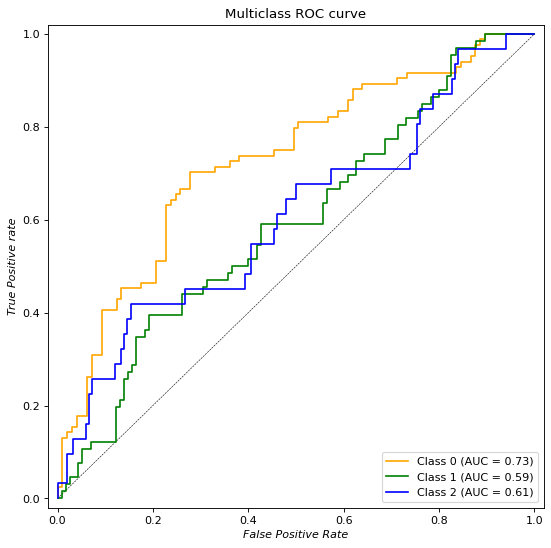

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, auc
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_style('italic')

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_class = 3
for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_label, pred[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 8), dpi=80)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.plot([0, 1], [0, 1], "k--", lw=0.5)
plt.plot(fpr[0], tpr[0], linestyle='-', color='orange', label='Class 0 (AUC = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-', color='green', label='Class 1 (AUC = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='-', color='blue', label='Class 2 (AUC = %0.2f)' % roc_auc[2])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate', fontproperties=font)
plt.ylabel('True Positive rate', fontproperties=font)
plt.legend(loc='lower right')
plt.show()

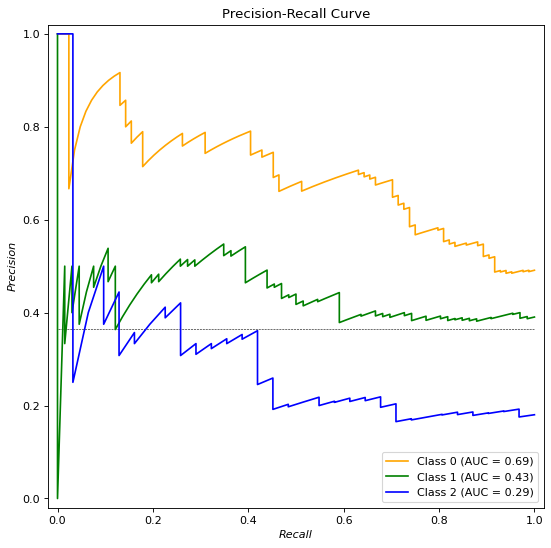

In [23]:
precision = {}
recall = {}
prc_auc = {}

n_class = 3

for i in range(n_class):
    precision[i], recall[i], _ = precision_recall_curve(y_label, pred[:, i], pos_label=i)
    prc_auc[i] = auc(recall[i], precision[i])

baseline = len(y_label[y_label == 1]) / len(y_label)

plt.figure(figsize=(8, 8), dpi=80)
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.plot([baseline, baseline], "k--", lw=0.5)
plt.plot(recall[0], precision[0], linestyle='-', color='orange', label='Class 0 (AUC = %0.2f)' % prc_auc[0])
plt.plot(recall[1], precision[1], linestyle='-', color='green', label='Class 1 (AUC = %0.2f)' % prc_auc[1])
plt.plot(recall[2], precision[2], linestyle='-', color='blue', label='Class 2 (AUC = %0.2f)' % prc_auc[2])
plt.title('Precision-Recall Curve')
plt.xlabel('Recall', fontproperties=font)
plt.ylabel('Precision', fontproperties=font)
plt.legend(loc='lower right')
plt.show()

In [24]:
predict = np.zeros((370,3))
for j in range(3):
  for i in range (len(prediction)):
    predict[i,j] = prediction[i, 0, j]

In [26]:
pred = pd.DataFrame(predict)
filepath = '/content/gdrive/My Drive/Result.xlsx'
pred.to_excel(filepath, index=False)